## Homework 02-2: due 2024/04/10 12:20 (85%)


## Learning Resources

### Tutorials
1. [CIFAR-10 Images Classification Using CNNs (88% Accuracy)](https://www.kaggle.com/code/faressayah/cifar-10-images-classification-using-cnns-88)
2. [CIFAR10 with CNN for Beginners](https://www.kaggle.com/code/roblexnana/cifar10-with-cnn-for-beginer)
3. [Classifying CIFAR-10 Using a Simple CNN](https://medium.com/analytics-vidhya/classifying-cifar-10-using-a-simple-cnn-4e9a6dd7600b)
4. [PyTorch Tutorial: Training a Classifier on CIFAR-10](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

### Benchmark References
For designing optimal model architectures, you may refer to:
1. [State-of-the-Art Image Classification on CIFAR-10](https://paperswithcode.com/sota/image-classification-on-cifar-10)
2. [State-of-the-Art Image Classification on CIFAR-100](https://paperswithcode.com/sota/image-classification-on-cifar-100)

## Assignment Instructions

After completing the tutorials, you should have the necessary knowledge to work on this assignment. Please answer all required questions and choose one of the following submission formats:

### Submission Option 1
Work directly in this Jupyter notebook, ensuring all code runs properly and displays results with embedded figures. Submit the completed notebook file.

### Submission Option 2
Organize your work as a structured project with multiple Python files. If you choose this option, include a detailed README file to help me reproducing your work.
##### README templete: https://github.com/othneildrew/Best-README-Template

#### Project Structure Example for Submission Option 2


In [ ]:
HM2/
├── datasets/              # Data directory
│   ├── birds/            # Bird image dataset
│   ├── cars/             # Car image dataset
│   └── ...               # Other dataset categories
├── model.py              # Custom model implementations
├── dataset.py            # Functions for data loading and preprocessing
├── main.py               # Model training and validation code
├── test.py               # Functions for test dataset predictions
├── utils.py              # Helper functions (plotting, loss functions, etc.)
└── submission.csv        # Kaggle submission file

# Classification Model Training Assignment

## Overview
In this assignment, you will build a classification model using the dataset available on Kaggle. Your task includes data preprocessing, model development, training, and evaluation against a baseline performance metric.

## Dataset
You can download the required dataset from kaggle: https://www.kaggle.com/t/ad6b3b848f5644d9a9e8df38e38ebcb5

## Grading Criteria

Your assignment will be evaluated based on the following components:

1. **Data Loading and Preprocessing (10%)**
   - Properly importing, cleaning, splitting the dataset
   - Exploratory data processing by transforming, up/downsampling, or other method

2. **Custom Model Definition (30%)**
   - Designing an appropriate model architecture
   - Explaining your choice of model or how you modify it

3. **Model Training (10%)**
   - Basi training procedures
   - Appropriate optimization and loss function

4. **Training Result Visualization (10%)**
   - Plotting relevant metrics or curve over training epochs

5. **Performance Evaluation (40%)**
   - Passing the baseline performance threshold

# Requirements about custom model


You should not simply use pre-existing models without modification. Instead, you are required to demonstrate originality in one of the following ways:

1. **Build your own model from scratch** using PyTorch or another framework
2. **Modify an existing model architecture** by implementing meaningful changes such as:
   - Increasing model width (expanding channel sizes)
   - Increasing model depth (adding more layers)
   - Altering pooling mechanisms
   - Changing activation functions
   - Incorporating residual connections or other advanced modules
   - Redesigning critical components of the architecture
   - And more...

Note that superficial changes, such as merely adjusting input/output dimensions to fit our dataset, will not satisfy the custom model requirement. Your modifications should reflect thoughtful architectural decisions that could potentially improve performance on this specific task.

Useful Pytorch tutorials: https://www.learnpytorch.io/00_pytorch_fundamentals/

# Note
1. DO NOT MODIFY THE SEEDS, you should include them in your code no mather you choose submission option1 or option2
2. Please simply add comments above your modify part in your suctom model class (or function) to explain why such modification.


### Import necessory modules

In [25]:
%matplotlib inline
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F  
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
import cv2
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split
import sys
import time
from PIL import Image

### SEEDS

In [26]:
# For reproduce the result
torch.manual_seed(1220)
random.seed(1220)
np.random.seed(1220)

### Some necessary settings

In [27]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("You are using device: %s" % device)
print("You are using PyTorch version: %s" % torch.__version__)

# define class names
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# define the path to the dataset
path_dataset = "datasets/"

You are using device: cuda
You are using PyTorch version: 2.3.0


### 1. Data Loading and Preprocessing (10%)

In [ ]:
def load_dataset(path_dataset):
    # Data transformations for training
    transform_train = transforms.Compose([
        transforms.Resize([32, 32]),  
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    # Data transformations for testing
    transform_test = transforms.Compose([
        transforms.Resize([32, 32]),  
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    # Create a non-augmented(no need for normalize) transform for visualization
    transform_noaug = transforms.Compose([
        transforms.Resize([32, 32]),
        transforms.ToTensor()
    ])
    
    # load custom dataset
    full_dataset = torchvision.datasets.ImageFolder(
        root=path_dataset,
        transform=transform_train
    )
    # also for visualization
    full_dataset_noaug = torchvision.datasets.ImageFolder(
        root=path_dataset,
        transform=transform_noaug
    )
    
    # Split dataset into training and validation sets (8:2)
    dataset_size = len(full_dataset)
    train_size = int(0.8 * dataset_size)
    val_size = dataset_size - train_size
    
    trainset, valset = random_split(full_dataset, [train_size, val_size])
    
    # Create data loaders
    trainloader = DataLoader(
        trainset, batch_size=128, shuffle=True, num_workers=2
    )
    
    valloader = DataLoader(
        valset, batch_size=100, shuffle=False, num_workers=2
    )
    
    
    # Map folder names to class names
    class_map = {i: full_dataset.classes[i] for i in range(len(full_dataset.classes))}
    print(f"Dataset classes: {class_map}")

    global classes
    if len(full_dataset.classes) == len(classes):
        print("Using predefined class names")
    else:
        print("Using classes from dataset folder structure")
        classes = full_dataset.classes
    
    return trainloader, valloader, full_dataset_noaug

# Define a composite transform for data augmentation for "visualizations" only, you can try to implement it for training
train_transformer_agumentation = transforms.Compose([
    transforms.ToPILImage(),  # Convert tensor to PIL Image (the format for transforms)
    transforms.RandomChoice([
        transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
        transforms.RandomRotation(90),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomAffine(degrees=0, shear=(0, 0, 0, 45)),
        transforms.RandomPerspective(distortion_scale=0.5, fill=0),
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    ]),

    transforms.ToTensor(),  # Convert back to tensor (the format for models)
])

# Transform for inference
train_transformer_inference = transforms.Compose([
    transforms.Resize([32, 32]),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load dataset
trainloader, valloader, dataset_noaug = load_dataset(path_dataset)

Dataset classes: {0: 'bird', 1: 'car', 2: 'cat', 3: 'deer', 4: 'dog', 5: 'frog', 6: 'horse', 7: 'plane', 8: 'ship', 9: 'truck'}
Using predefined class names


### (optional) Data visualization

In [ ]:
# Showing training images from batch loading
def Show_Train_Images(trainset_show_noaug):
    fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(17, 8))
    index = 0
    for i in range(3):
        for j in range(3):
            axes[i, j].set_title(classes[trainset_show_noaug[index][1]])
            # Convert tensor to numpy 
            img = trainset_show_noaug[index][0].permute(1, 2, 0).numpy()
            axes[i, j].imshow(img)
            axes[i, j].get_xaxis().set_visible(False)
            axes[i, j].get_yaxis().set_visible(False)
            index += 1
    plt.show()
    return

def Show_Data_Augmentation(trainset_show):
    fig, axes = plt.subplots(ncols=3, nrows=4, figsize=(17, 16))
    
    for i in range(3):
        img = trainset_show[i][0].permute(1, 2, 0).numpy()
        axes[0, i].set_title(f'Original {classes[trainset_show[i][1]]}')
        axes[0, i].imshow(img)
        axes[0, i].get_xaxis().set_visible(False)
        axes[0, i].get_yaxis().set_visible(False)
    

    for row in range(1, 4):
        for i in range(3):
            # Apply augmentation - generate a new augmentation each time
            aug_img = train_transformer_agumentation(trainset_show[i][0])
            # Convert tensor to numpy for display
            aug_img = aug_img.permute(1, 2, 0).numpy()
            axes[row, i].set_title(f'Aug {row} - {classes[trainset_show[i][1]]}')
            axes[row, i].imshow(aug_img)
            axes[row, i].get_xaxis().set_visible(False)
            axes[row, i].get_yaxis().set_visible(False)
    
    plt.tight_layout()
    plt.show()
    return


def Show_Augmentation_Grid(dataset, num_images=5, num_augmentations=5):
    # Select random images from the dataset
    indices = random.sample(range(len(dataset)), num_images)
    
  
    fig, axes = plt.subplots(nrows=num_images, ncols=num_augmentations+1, 
                            figsize=(3*(num_augmentations+1), 3*num_images))
    
    for row, idx in enumerate(indices):
        # Get original image and its label
        img, label = dataset[idx]
        
        # Display original image
        img_np = img.permute(1, 2, 0).numpy()
        axes[row, 0].set_title(f'Original {classes[label]}')
        axes[row, 0].imshow(img_np)
        axes[row, 0].axis('off')
        
        for col in range(1, num_augmentations+1):
            # Apply augmentation transform
            aug_img = train_transformer_agumentation(img)
            aug_img_np = aug_img.permute(1, 2, 0).numpy()
            
            # Display augmented image
            axes[row, col].set_title(f'Aug {col}')
            axes[row, col].imshow(aug_img_np)
            axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()
    return


# Create a subset for visualization (I select 10 random samples)
sample_indices = random.sample(range(len(dataset_noaug)), 10)
trainset_show = [dataset_noaug[i] for i in sample_indices]

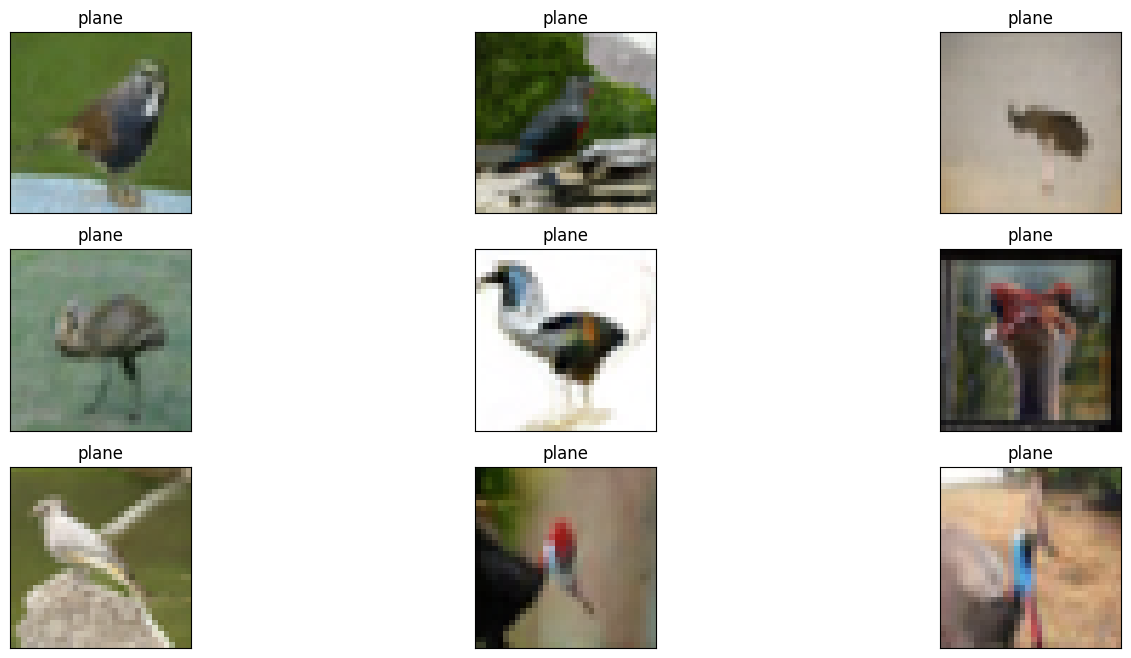

In [30]:
# Show training images
Show_Train_Images(dataset_noaug)

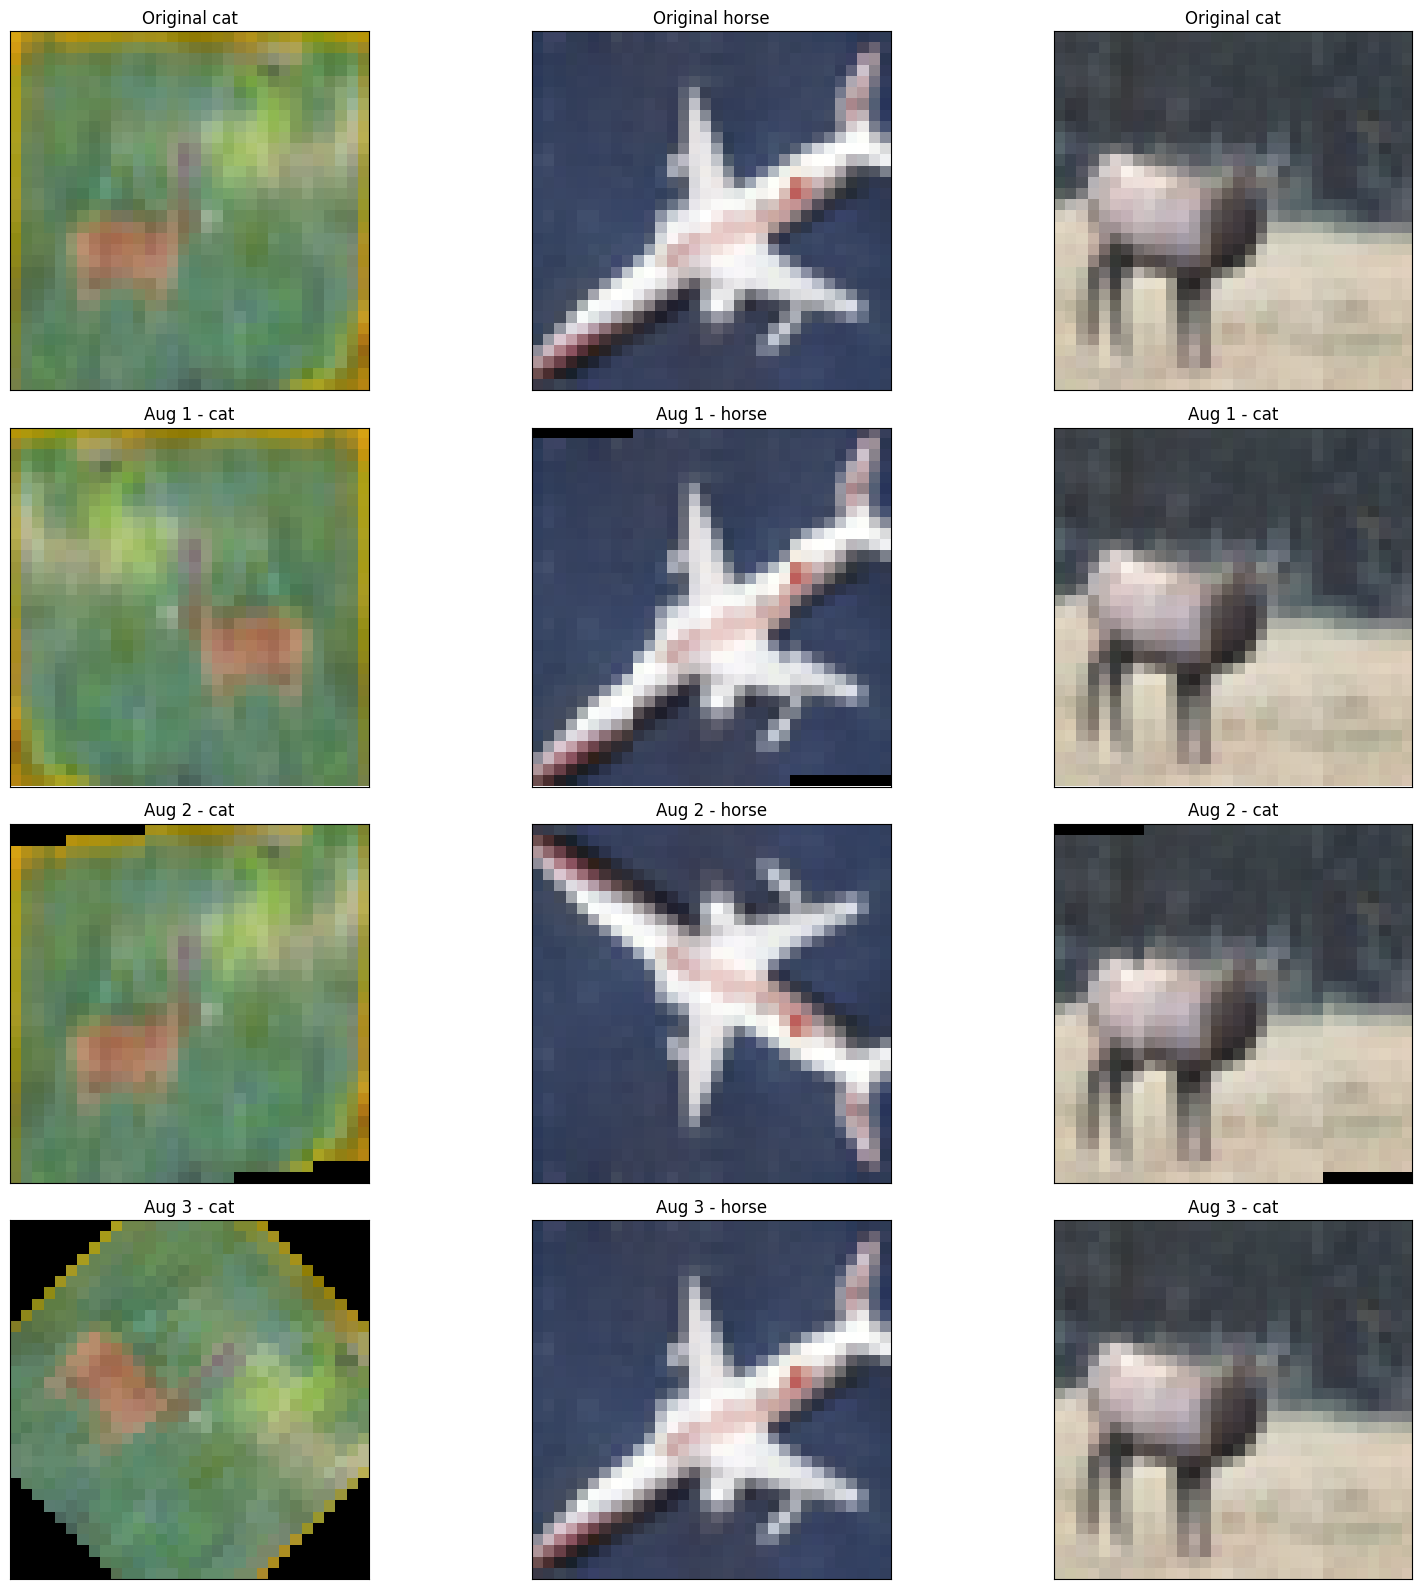

In [31]:
# Show data augmentation effects
Show_Data_Augmentation(trainset_show)


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x00000209D3AE0AF0>
Traceback (most recent call last):
  File "c:\Users\tsai_\.conda\envs\vit\lib\site-packages\torch\utils\data\dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "c:\Users\tsai_\.conda\envs\vit\lib\site-packages\torch\utils\data\dataloader.py", line 1437, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


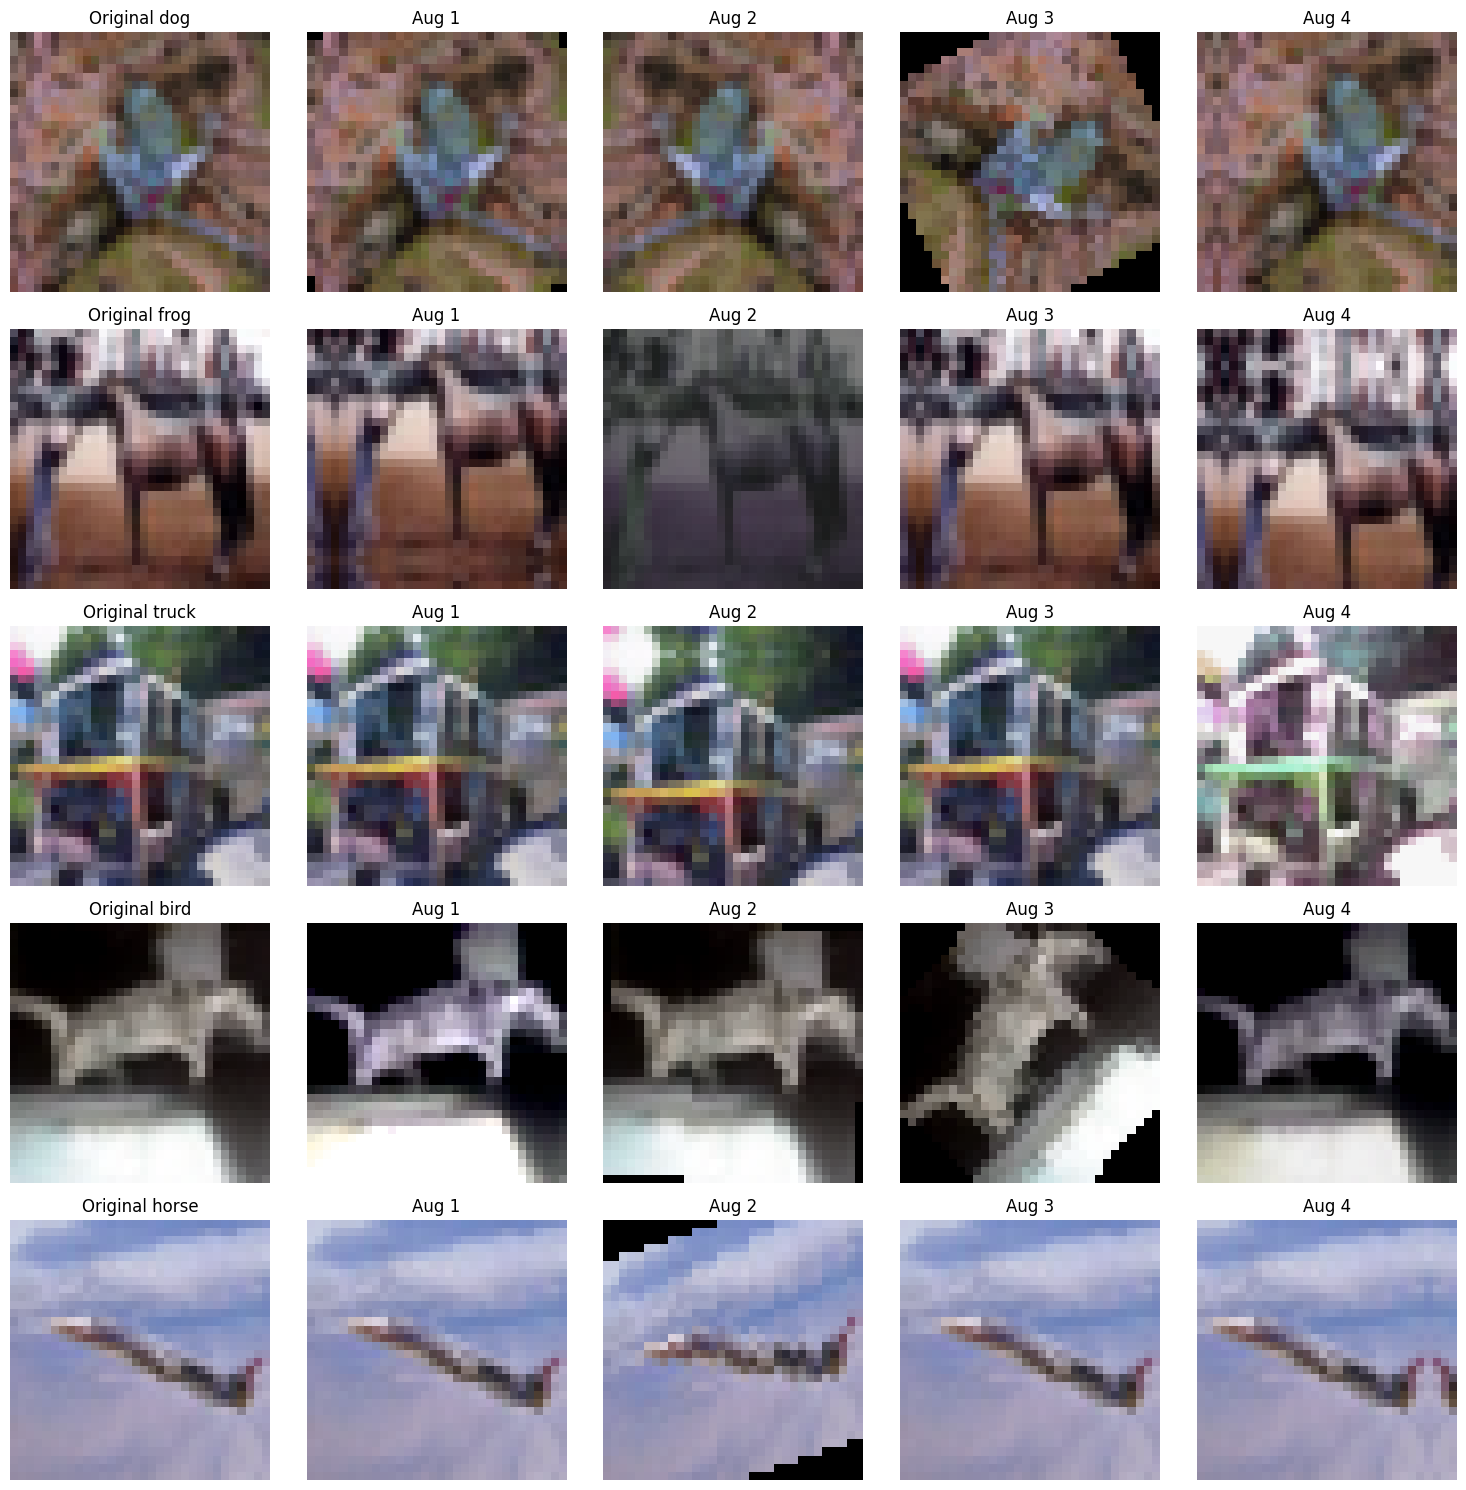

In [ ]:
# Show augmentation grid for more detailed visualization (ignore the error)
Show_Augmentation_Grid(dataset_noaug, num_images=5, num_augmentations=4)

### 2. Custom Model Definition (30%)

In [ ]:
# I only use a very simple CNN model as example, you can try to implement more complex models like ResNet, DenseNet, etc. then extend and experiment with them
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# create model object
model_ = SimpleCNN().to(device)
# torch.summary is a good tool to show the model architecture, need installation
# !pip install torchsummary
# from torchsummary import summary
# summary(model_, (3, 32, 32))
print(model_)



SimpleCNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


### Model Training (10%)

#### Training function

In [ ]:
def train(model, trainloader, valloader, epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    
    # Lists to store metrics for plotting
    # If you don't want to use this, there are plenty website and tools to visualize the training process, ex: TensorBoard, Weights & Biases, etc.
    # Just remember to zip them toghether as you submit the homwork
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    # Training loop
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Wrap trainloader with tqdm for progress bar to make it looks nicer
        loop = tqdm(enumerate(trainloader), total=len(trainloader), leave=True)
        for i, data in loop:
            # Get inputs and labels
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Update running loss
            running_loss += loss.item()
            
            # Update progress bar
            loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
            loop.set_postfix(loss=running_loss/(i+1), accuracy=100.*correct/total)
        
        # Calculate epoch statistics for training
        epoch_train_loss = running_loss / len(trainloader)
        epoch_train_acc = 100. * correct / total
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)
        
        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for data in valloader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                
                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                # Calculate validation loss
                val_running_loss += loss.item()
                
                # Calculate validation accuracy
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        # Calculate epoch statistics for validation
        epoch_val_loss = val_running_loss / len(valloader)
        epoch_val_acc = 100. * val_correct / val_total
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)
        
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%")
        print(f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%")
        print("-" * 60)
    
    print('Finished Training')
    
    return model, train_losses, train_accuracies, val_losses, val_accuracies



#### Evaluation function

In [ ]:
def evaluate(model, valloader):

    model.eval()
    correct = 0
    total = 0
    
    # Initialize lists for per-class accuracy
    num_classes = len(classes)
    class_correct = list(0. for i in range(num_classes))
    class_total = list(0. for i in range(num_classes))
    
    # Initialize confusion matrix
    confusion_matrix = torch.zeros(num_classes, num_classes)
    
    with torch.no_grad():
        for data in tqdm(valloader, desc="Evaluating"):
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Calculate per-class accuracy
            c = (predicted == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
                
                # Update confusion matrix
                confusion_matrix[label, predicted[i]] += 1

    overall_accuracy = 100 * correct / total
    print(f'Overall Accuracy: {overall_accuracy:.2f}%')

    
    return class_correct, class_total, confusion_matrix

#### Some tools

In [ ]:
def Save_Model():
    torch.save(model_.state_dict(), 'model.pth')
    print("Model saved successfully!")
    return

def Load_Model():
    model_.load_state_dict(torch.load('model.pth'))
    model_.eval()
    print("Model loaded successfully!")
    return

#### Training

In [ ]:
print("Starting training...")
trained_model, train_losses, train_accuracies, val_losses, val_accuracies = train(
    model_, trainloader, valloader, epochs=50
)

Starting training...


Epoch [1/50]: 100%|██████████| 44/44 [00:01<00:00, 26.97it/s, accuracy=11.9, loss=2.3]


Epoch 1/50
Train Loss: 2.2978, Train Acc: 11.89%
Val Loss: 2.3001, Val Acc: 11.79%
------------------------------------------------------------


Epoch [2/50]: 100%|██████████| 44/44 [00:01<00:00, 25.23it/s, accuracy=12.4, loss=2.3]


Epoch 2/50
Train Loss: 2.2971, Train Acc: 12.43%
Val Loss: 2.2989, Val Acc: 12.00%
------------------------------------------------------------


Epoch [3/50]: 100%|██████████| 44/44 [00:01<00:00, 28.95it/s, accuracy=13.1, loss=2.3]


Epoch 3/50
Train Loss: 2.2954, Train Acc: 13.05%
Val Loss: 2.2974, Val Acc: 13.43%
------------------------------------------------------------


Epoch [4/50]: 100%|██████████| 44/44 [00:01<00:00, 28.35it/s, accuracy=13.1, loss=2.29]


Epoch 4/50
Train Loss: 2.2939, Train Acc: 13.14%
Val Loss: 2.2959, Val Acc: 12.43%
------------------------------------------------------------


Epoch [5/50]: 100%|██████████| 44/44 [00:01<00:00, 28.62it/s, accuracy=13.2, loss=2.29]


Epoch 5/50
Train Loss: 2.2918, Train Acc: 13.20%
Val Loss: 2.2930, Val Acc: 12.21%
------------------------------------------------------------


Epoch [6/50]: 100%|██████████| 44/44 [00:01<00:00, 28.20it/s, accuracy=13.4, loss=2.29]


Epoch 6/50
Train Loss: 2.2888, Train Acc: 13.39%
Val Loss: 2.2891, Val Acc: 13.93%
------------------------------------------------------------


Epoch [7/50]: 100%|██████████| 44/44 [00:01<00:00, 29.30it/s, accuracy=13.1, loss=2.29]


Epoch 7/50
Train Loss: 2.2856, Train Acc: 13.14%
Val Loss: 2.2857, Val Acc: 12.86%
------------------------------------------------------------


Epoch [8/50]: 100%|██████████| 44/44 [00:01<00:00, 29.51it/s, accuracy=13.9, loss=2.28]


Epoch 8/50
Train Loss: 2.2814, Train Acc: 13.88%
Val Loss: 2.2814, Val Acc: 13.21%
------------------------------------------------------------


Epoch [9/50]: 100%|██████████| 44/44 [00:01<00:00, 24.54it/s, accuracy=13.6, loss=2.28]


Epoch 9/50
Train Loss: 2.2763, Train Acc: 13.61%
Val Loss: 2.2755, Val Acc: 12.36%
------------------------------------------------------------


Epoch [10/50]: 100%|██████████| 44/44 [00:01<00:00, 28.34it/s, accuracy=13.4, loss=2.27]


Epoch 10/50
Train Loss: 2.2685, Train Acc: 13.36%
Val Loss: 2.2675, Val Acc: 12.64%
------------------------------------------------------------


Epoch [11/50]: 100%|██████████| 44/44 [00:01<00:00, 30.88it/s, accuracy=14, loss=2.26]  


Epoch 11/50
Train Loss: 2.2610, Train Acc: 13.98%
Val Loss: 2.2573, Val Acc: 13.86%
------------------------------------------------------------


Epoch [12/50]: 100%|██████████| 44/44 [00:01<00:00, 30.16it/s, accuracy=14.7, loss=2.25]


Epoch 12/50
Train Loss: 2.2492, Train Acc: 14.73%
Val Loss: 2.2475, Val Acc: 15.50%
------------------------------------------------------------


Epoch [13/50]: 100%|██████████| 44/44 [00:01<00:00, 30.54it/s, accuracy=16.3, loss=2.24]


Epoch 13/50
Train Loss: 2.2394, Train Acc: 16.34%
Val Loss: 2.2335, Val Acc: 17.07%
------------------------------------------------------------


Epoch [14/50]: 100%|██████████| 44/44 [00:01<00:00, 29.04it/s, accuracy=17.8, loss=2.22]


Epoch 14/50
Train Loss: 2.2249, Train Acc: 17.75%
Val Loss: 2.2156, Val Acc: 17.93%
------------------------------------------------------------


Epoch [15/50]: 100%|██████████| 44/44 [00:01<00:00, 28.82it/s, accuracy=17.9, loss=2.21]


Epoch 15/50
Train Loss: 2.2090, Train Acc: 17.91%
Val Loss: 2.2025, Val Acc: 19.36%
------------------------------------------------------------


Epoch [16/50]: 100%|██████████| 44/44 [00:01<00:00, 28.84it/s, accuracy=18.8, loss=2.19]


Epoch 16/50
Train Loss: 2.1912, Train Acc: 18.82%
Val Loss: 2.1847, Val Acc: 20.14%
------------------------------------------------------------


Epoch [17/50]: 100%|██████████| 44/44 [00:01<00:00, 28.92it/s, accuracy=20.9, loss=2.17]


Epoch 17/50
Train Loss: 2.1735, Train Acc: 20.86%
Val Loss: 2.1655, Val Acc: 21.93%
------------------------------------------------------------


Epoch [18/50]: 100%|██████████| 44/44 [00:01<00:00, 28.84it/s, accuracy=21.2, loss=2.15]


Epoch 18/50
Train Loss: 2.1497, Train Acc: 21.23%
Val Loss: 2.1478, Val Acc: 21.64%
------------------------------------------------------------


Epoch [19/50]: 100%|██████████| 44/44 [00:01<00:00, 31.06it/s, accuracy=21.3, loss=2.13]


Epoch 19/50
Train Loss: 2.1304, Train Acc: 21.27%
Val Loss: 2.1264, Val Acc: 21.79%
------------------------------------------------------------


Epoch [20/50]: 100%|██████████| 44/44 [00:01<00:00, 31.34it/s, accuracy=22.8, loss=2.11]


Epoch 20/50
Train Loss: 2.1082, Train Acc: 22.79%
Val Loss: 2.1022, Val Acc: 21.71%
------------------------------------------------------------


Epoch [21/50]: 100%|██████████| 44/44 [00:01<00:00, 31.57it/s, accuracy=21.9, loss=2.09]


Epoch 21/50
Train Loss: 2.0936, Train Acc: 21.86%
Val Loss: 2.0871, Val Acc: 22.07%
------------------------------------------------------------


Epoch [22/50]: 100%|██████████| 44/44 [00:01<00:00, 30.49it/s, accuracy=22.8, loss=2.07]


Epoch 22/50
Train Loss: 2.0736, Train Acc: 22.82%
Val Loss: 2.0659, Val Acc: 24.29%
------------------------------------------------------------


Epoch [23/50]: 100%|██████████| 44/44 [00:01<00:00, 29.68it/s, accuracy=23.7, loss=2.06]


Epoch 23/50
Train Loss: 2.0592, Train Acc: 23.71%
Val Loss: 2.0646, Val Acc: 23.64%
------------------------------------------------------------


Epoch [24/50]: 100%|██████████| 44/44 [00:01<00:00, 27.94it/s, accuracy=23.5, loss=2.05]


Epoch 24/50
Train Loss: 2.0485, Train Acc: 23.46%
Val Loss: 2.0498, Val Acc: 23.21%
------------------------------------------------------------


Epoch [25/50]: 100%|██████████| 44/44 [00:01<00:00, 28.87it/s, accuracy=24.3, loss=2.04]


Epoch 25/50
Train Loss: 2.0389, Train Acc: 24.32%
Val Loss: 2.0437, Val Acc: 23.50%
------------------------------------------------------------


Epoch [26/50]: 100%|██████████| 44/44 [00:01<00:00, 28.72it/s, accuracy=24.2, loss=2.03]


Epoch 26/50
Train Loss: 2.0308, Train Acc: 24.18%
Val Loss: 2.0396, Val Acc: 24.00%
------------------------------------------------------------


Epoch [27/50]: 100%|██████████| 44/44 [00:01<00:00, 28.71it/s, accuracy=24.8, loss=2.02]


Epoch 27/50
Train Loss: 2.0192, Train Acc: 24.80%
Val Loss: 2.0253, Val Acc: 24.00%
------------------------------------------------------------


Epoch [28/50]: 100%|██████████| 44/44 [00:01<00:00, 29.07it/s, accuracy=25.1, loss=2.01]


Epoch 28/50
Train Loss: 2.0114, Train Acc: 25.12%
Val Loss: 2.0192, Val Acc: 24.79%
------------------------------------------------------------


Epoch [29/50]: 100%|██████████| 44/44 [00:01<00:00, 29.82it/s, accuracy=25.4, loss=2.01]


Epoch 29/50
Train Loss: 2.0088, Train Acc: 25.39%
Val Loss: 2.0104, Val Acc: 25.21%
------------------------------------------------------------


Epoch [30/50]: 100%|██████████| 44/44 [00:01<00:00, 30.23it/s, accuracy=25.4, loss=2]   


Epoch 30/50
Train Loss: 1.9975, Train Acc: 25.45%
Val Loss: 2.0112, Val Acc: 25.71%
------------------------------------------------------------


Epoch [31/50]: 100%|██████████| 44/44 [00:01<00:00, 29.89it/s, accuracy=26, loss=1.99]  


Epoch 31/50
Train Loss: 1.9884, Train Acc: 26.00%
Val Loss: 2.0127, Val Acc: 24.50%
------------------------------------------------------------


Epoch [32/50]: 100%|██████████| 44/44 [00:01<00:00, 29.08it/s, accuracy=26.4, loss=1.99]


Epoch 32/50
Train Loss: 1.9854, Train Acc: 26.36%
Val Loss: 2.0031, Val Acc: 24.93%
------------------------------------------------------------


Epoch [33/50]: 100%|██████████| 44/44 [00:01<00:00, 28.63it/s, accuracy=25.7, loss=1.98]


Epoch 33/50
Train Loss: 1.9796, Train Acc: 25.68%
Val Loss: 2.0159, Val Acc: 24.29%
------------------------------------------------------------


Epoch [34/50]: 100%|██████████| 44/44 [00:01<00:00, 29.70it/s, accuracy=26.1, loss=1.98]


Epoch 34/50
Train Loss: 1.9768, Train Acc: 26.14%
Val Loss: 1.9851, Val Acc: 26.57%
------------------------------------------------------------


Epoch [35/50]: 100%|██████████| 44/44 [00:01<00:00, 29.02it/s, accuracy=26.3, loss=1.96]


Epoch 35/50
Train Loss: 1.9641, Train Acc: 26.29%
Val Loss: 1.9720, Val Acc: 27.79%
------------------------------------------------------------


Epoch [36/50]: 100%|██████████| 44/44 [00:01<00:00, 29.86it/s, accuracy=27.6, loss=1.96]


Epoch 36/50
Train Loss: 1.9599, Train Acc: 27.59%
Val Loss: 1.9730, Val Acc: 26.57%
------------------------------------------------------------


Epoch [37/50]: 100%|██████████| 44/44 [00:01<00:00, 29.07it/s, accuracy=27.6, loss=1.95]


Epoch 37/50
Train Loss: 1.9508, Train Acc: 27.59%
Val Loss: 1.9740, Val Acc: 27.86%
------------------------------------------------------------


Epoch [38/50]: 100%|██████████| 44/44 [00:01<00:00, 29.31it/s, accuracy=27.2, loss=1.95]


Epoch 38/50
Train Loss: 1.9451, Train Acc: 27.16%
Val Loss: 1.9553, Val Acc: 27.07%
------------------------------------------------------------


Epoch [39/50]: 100%|██████████| 44/44 [00:01<00:00, 29.24it/s, accuracy=28, loss=1.93]  


Epoch 39/50
Train Loss: 1.9327, Train Acc: 28.04%
Val Loss: 1.9553, Val Acc: 27.07%
------------------------------------------------------------


Epoch [40/50]: 100%|██████████| 44/44 [00:01<00:00, 29.78it/s, accuracy=28, loss=1.93]  


Epoch 40/50
Train Loss: 1.9321, Train Acc: 27.96%
Val Loss: 1.9568, Val Acc: 25.64%
------------------------------------------------------------


Epoch [41/50]: 100%|██████████| 44/44 [00:01<00:00, 29.85it/s, accuracy=27.9, loss=1.92]


Epoch 41/50
Train Loss: 1.9237, Train Acc: 27.89%
Val Loss: 1.9493, Val Acc: 28.14%
------------------------------------------------------------


Epoch [42/50]: 100%|██████████| 44/44 [00:01<00:00, 29.54it/s, accuracy=28.7, loss=1.91]


Epoch 42/50
Train Loss: 1.9120, Train Acc: 28.66%
Val Loss: 1.9393, Val Acc: 27.00%
------------------------------------------------------------


Epoch [43/50]: 100%|██████████| 44/44 [00:01<00:00, 30.12it/s, accuracy=28.8, loss=1.91]


Epoch 43/50
Train Loss: 1.9083, Train Acc: 28.79%
Val Loss: 1.9362, Val Acc: 27.93%
------------------------------------------------------------


Epoch [44/50]: 100%|██████████| 44/44 [00:01<00:00, 30.52it/s, accuracy=29.5, loss=1.9] 


Epoch 44/50
Train Loss: 1.8992, Train Acc: 29.50%
Val Loss: 1.9260, Val Acc: 27.86%
------------------------------------------------------------


Epoch [45/50]: 100%|██████████| 44/44 [00:01<00:00, 30.01it/s, accuracy=28.8, loss=1.9] 


Epoch 45/50
Train Loss: 1.8955, Train Acc: 28.84%
Val Loss: 1.9076, Val Acc: 29.71%
------------------------------------------------------------


Epoch [46/50]: 100%|██████████| 44/44 [00:01<00:00, 30.44it/s, accuracy=29.1, loss=1.89]


Epoch 46/50
Train Loss: 1.8870, Train Acc: 29.09%
Val Loss: 1.9167, Val Acc: 28.36%
------------------------------------------------------------


Epoch [47/50]: 100%|██████████| 44/44 [00:01<00:00, 29.99it/s, accuracy=29.9, loss=1.88]


Epoch 47/50
Train Loss: 1.8820, Train Acc: 29.86%
Val Loss: 1.9054, Val Acc: 28.57%
------------------------------------------------------------


Epoch [48/50]: 100%|██████████| 44/44 [00:01<00:00, 28.97it/s, accuracy=30.9, loss=1.87]


Epoch 48/50
Train Loss: 1.8690, Train Acc: 30.93%
Val Loss: 1.8890, Val Acc: 29.43%
------------------------------------------------------------


Epoch [49/50]: 100%|██████████| 44/44 [00:01<00:00, 28.47it/s, accuracy=29.5, loss=1.86]


Epoch 49/50
Train Loss: 1.8645, Train Acc: 29.54%
Val Loss: 1.8895, Val Acc: 29.29%
------------------------------------------------------------


Epoch [50/50]: 100%|██████████| 44/44 [00:01<00:00, 29.52it/s, accuracy=30.5, loss=1.85]


Epoch 50/50
Train Loss: 1.8524, Train Acc: 30.46%
Val Loss: 1.8963, Val Acc: 29.00%
------------------------------------------------------------
Finished Training


#### Evaluating

In [57]:
print("Starting evaluating...")
class_correct, class_total, confusion_matrix = evaluate(trained_model, valloader)

Starting evaluating...


Evaluating: 100%|██████████| 14/14 [00:05<00:00,  2.54it/s]

Overall Accuracy: 29.43%


### Training Result Visualization (10%)

#### Plot function

In [ ]:
def plot_training_metrics(train_losses, train_accuracies, val_losses, val_accuracies):

    epochs = range(1, len(train_losses) + 1)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(epochs, train_losses, 'b-', label='Training Loss')
    ax1.plot(epochs, val_losses, 'r-', label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    ax2.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
    ax2.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    fig.savefig('training_metrics.png')
    print("Training metrics plot saved as 'training_metrics.png'")
    return

In [ ]:
def plot_evaluation_metrics(class_correct, class_total, confusion_matrix):

    num_classes = len(classes)
    
    # Calculate accuracies and identify valid classes
    accuracies = []
    valid_classes = []
    
    print("\nPer-class Accuracy:")
    print("-" * 50)
    for i in range(num_classes):
        if class_total[i] > 0:  # Avoid division by zero
            accuracy = 100 * class_correct[i] / class_total[i]
            print(f'{classes[i]}: {accuracy:.2f}% ({int(class_correct[i])}/{int(class_total[i])})')
            accuracies.append(accuracy)
            valid_classes.append(classes[i])
        else:
            print(f'{classes[i]}: No samples')
    
    # Plot per-class accuracy as a bar chart
    plt.figure(figsize=(12, 6))
    plt.bar(valid_classes, accuracies, color='skyblue')
    plt.xlabel('Classes')
    plt.ylabel('Accuracy (%)')
    plt.title('Per-class Accuracy')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('per_class_accuracy.png')
    plt.show()
    
    # Normalize confusion matrix by row (true labels) and plot
    normalized_confusion_matrix = confusion_matrix.clone()  # Create a copy to avoid modifying the original
    for i in range(num_classes):
        if normalized_confusion_matrix[i].sum() > 0:
            normalized_confusion_matrix[i] = normalized_confusion_matrix[i] / normalized_confusion_matrix[i].sum()
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    plt.imshow(normalized_confusion_matrix.cpu().numpy(), interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Normalized Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, classes, rotation=45, ha='right')
    plt.yticks(tick_marks, classes)
   
    thresh = normalized_confusion_matrix.cpu().numpy().max() / 2.0
    for i in range(num_classes):
        for j in range(num_classes):
            plt.text(j, i, f'{normalized_confusion_matrix[i, j]:.2f}',
                     horizontalalignment="center",
                     color="white" if normalized_confusion_matrix[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion_matrix.png')
    plt.show()
    
    return

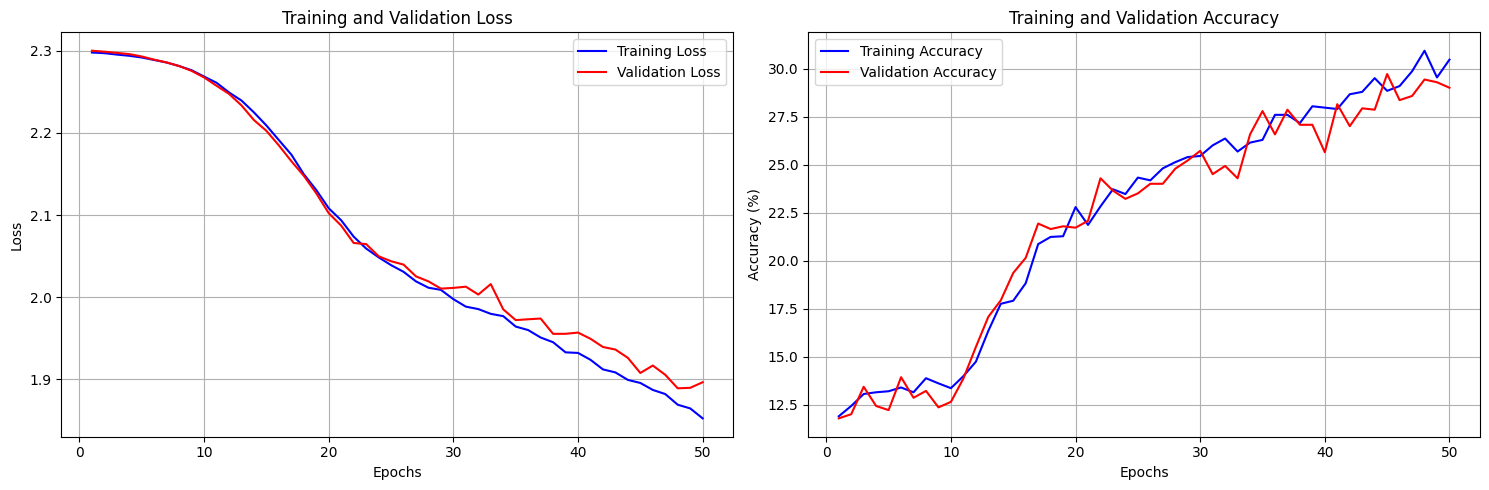

Training metrics plot saved as 'training_metrics.png'


In [ ]:
plot_training_metrics(train_losses, train_accuracies, val_losses, val_accuracies)


Per-class Accuracy:
--------------------------------------------------
plane: 3.15% (4/127)
car: 30.16% (38/126)
bird: 13.49% (17/126)
cat: 6.85% (10/146)
deer: 36.23% (50/138)
dog: 48.68% (74/152)
frog: 36.55% (53/145)
horse: 45.26% (62/137)
ship: 31.17% (48/154)
truck: 37.58% (56/149)


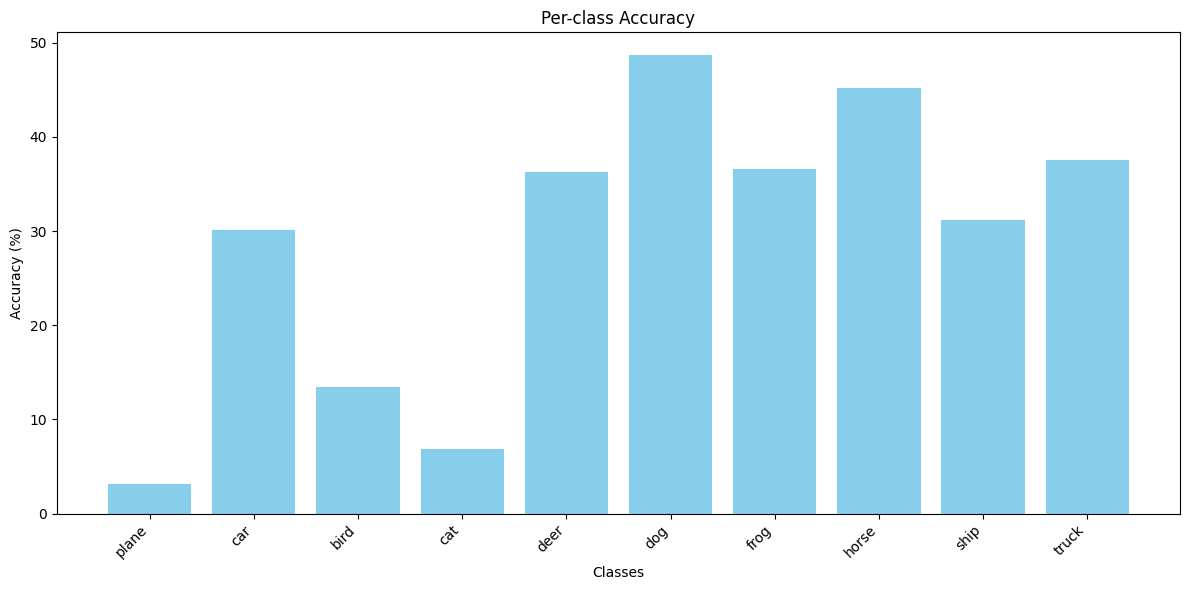

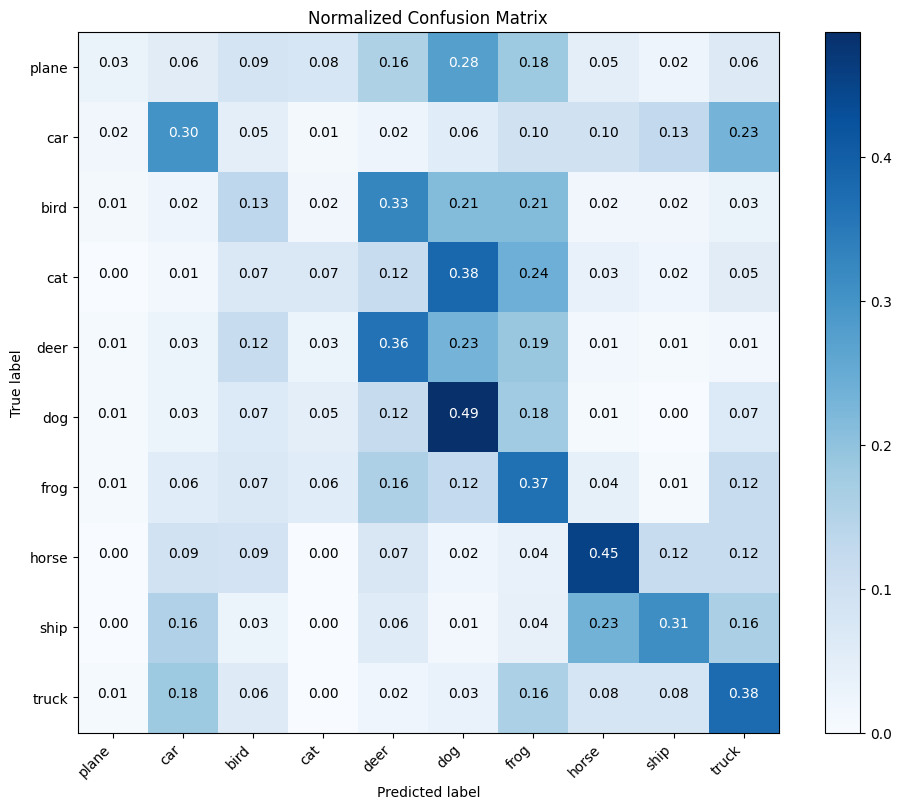

In [ ]:
plot_evaluation_metrics(class_correct, class_total, confusion_matrix)

#### Remember to save your model

In [59]:
Save_Model()

Model saved successfully!


### Performance Evaluation (40%)

#### Generate prediction

In [65]:
import os
# Change this part to your path
test_folder_path="dataset_test"        
csv_file_path="submission_example.csv"
model_path="model.pth"
file_extension=".png"           


# Load CSV file
df = pd.read_csv(csv_file_path)
print(f"Loaded CSV with {len(df)} entries")

# Get column names
columns = df.columns.tolist()
first_col = columns[0]  # Image name column
second_col = columns[1]  # Empty column for predictions

# Load model
model_.load_state_dict(torch.load(model_path, map_location=device))
model_.to(device)
model_.eval()

# Set up transformation (same as we set up earlier in the dataloaidng part, put I put here again for clarity)
transform = transforms.Compose([
    transforms.Resize([32, 32]),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


for idx, row in tqdm(df.iterrows(), total=len(df)):
    try:
        img_name = str(row[first_col]).strip()
        
        img_path = os.path.join(test_folder_path, img_name + file_extension)
               
        # Process the image
        img = Image.open(img_path).convert('RGB')
        img_tensor = transform(img).unsqueeze(0).to(device)
        
        # Predict
        with torch.no_grad():
            output = model_(img_tensor)
            _, predicted = torch.max(output.data, 1)
            predicted_idx = predicted.item()
        
        # Update CSV
        df.at[idx, second_col] = predicted_idx
        
    except Exception as e:
        print(f"Error with image {img_name}: {e}")

# Save updated CSV
df.to_csv(csv_file_path, index=False)
print(f"Updated CSV saved to {csv_file_path}")





Loaded CSV with 3000 entries


100%|██████████| 3000/3000 [00:04<00:00, 655.69it/s]

Updated CSV saved to submission_example.csv
